## Connect to drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/SecondCompetition

/content/drive/My Drive/SecondCompetition


# Initialization

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os

import matplotlib.pyplot as plt
import seaborn as sns

# import keras_tuner as kt

from tqdm import tqdm

#import warnings
#warnings.filterwarnings('ignore')
#tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tfk.layers

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
DATASET_FILE = 'Training.csv'

# Decide whether to use scaling or normalization
USE_MIN_MAX_NORM = 'MinMax'    # Interval: [0:1]
USE_MEAN_STD_SCALE = 'MeanStd'

FREQUENCY = 96    # Relevant frequency to build additional sin and cos columns
ADD_SIN = False    # Flags to decide which columns to add to the dataset
ADD_COS = False

BATCH_SIZE = 64
EPOCHES = 200

TEST_SIZE = 864
TELESCOPE = 24
WINDOW_SIZE = 480
STRIDE = 24
CONST_THRESHOLD = 0.1    # Maximum fraction of telescope values that can be corrupted whithin a window
MIN_CONST_NUM = 10    # Minimum number of successive constant samples to consider a signal corrupted

TARGET_LABELS = ['Sponginess',
                  'Wonder level',
                  'Crunchiness',
                  'Loudness on impact',
                  'Meme creativity',
                  'Soap slipperiness',
                  'Hype root']

# Dataset preparation

In [ ]:
df = pd.read_csv(DATASET_FILE).astype('float32')    # Cast necessary?
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68528 entries, 0 to 68527
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sponginess          68528 non-null  float32
 1   Wonder level        68528 non-null  float32
 2   Crunchiness         68528 non-null  float32
 3   Loudness on impact  68528 non-null  float32
 4   Meme creativity     68528 non-null  float32
 5   Soap slipperiness   68528 non-null  float32
 6   Hype root           68528 non-null  float32
dtypes: float32(7)
memory usage: 1.8 MB


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
count,68528.000000,68528.000000,68528.000000,68528.000000,68528.000000,68528.000000,68528.000000
mean,6.093986,4.695582,13.337390,2.448718,2.407179,23.237875,8.231431
std,1.941717,3.374214,11.702990,3.001717,0.994042,14.297975,11.285133
min,-0.972080,-8.450379,-37.581722,-9.028060,-1.275860,-6.006860,-42.769222
25%,4.791440,2.223420,10.672820,0.468800,2.112200,12.560241,6.604160
50%,5.702780,4.668600,15.676060,2.533840,2.618500,20.151419,10.968300
75%,7.067300,7.115440,20.568081,4.656980,3.021880,31.245199,15.334101
max,15.106680,18.122900,41.138802,14.035980,6.056360,77.371620,31.024420


# Dataset Preparation

In [ ]:
# Add columns of sin and cosine with frequency 96
def add_freq_columns(df, freq=FREQUENCY, add_sin=ADD_SIN, add_cos=ADD_COS):
    
    temp = [i for i in range(len(df))]
    if add_sin:
        df['freq_sin'] = [np.sin(val * (2 * np.pi / freq)) for val in temp]
    if add_cos:
        df['freq_cos'] = [np.cos(val * (2 * np.pi / freq)) for val in temp]
            
    return df

In [ ]:
# Normalizes the dataframe wrt the normalization type specified
def normalize_dataframe(df, norm_type = USE_MIN_MAX_NORM):

    if norm_type == USE_MIN_MAX_NORM:
        
        df_min = df.min()
        df_max = df.max()

        df = (df-df_min)/(df_max-df_min)

    elif norm_type == USE_MEAN_STD_SCALE:
        
        df_mean = df.mean()
        df_std = df.std()

        df = (df-df_mean)/df_std
        
    return df

In [ ]:
# Plots the columns of the dataset in the range 'plt_range'

# Intresting ranges
#plt_range=(37000,38000) Sponginess flatline
#plt_range=(15000,15500) All signals flatline
#plt_range=(0,10000)

def inspect_dataframe(df, columns=None, plt_range=None, line_width=0.3):
    if columns is None:
        columns = df.columns
    if plt_range is None:
        plt_range = (0,len(df))
    plt.rcParams.update({'font.size': 20})
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(40,30))
    for i, col in enumerate(columns):
        axs[i].plot(df[col][plt_range[0]:plt_range[1]], linewidth=line_width)
        axs[i].set_title(col)
    plt.show()

In [ ]:
df = add_freq_columns(df)
X_train_raw = normalize_dataframe(df)
# inspect_dataframe(X_train_raw, X_train_raw.columns, plt_range=(60000,61000))

In [ ]:
# returns the number of constant samples in the given signals

# num_sig = number of signals to consider
# min_const_num = minimum number of successive constant samples to consider a signal corrupted
def count_constants(signal_arr, num_sig, min_const_num = MIN_CONST_NUM):
    tot = 0
    for col in range(num_sig):
        count = 0
        curr = signal_arr[0][col]
        for el in signal_arr[:,col]:
            if el == curr:
                count += 1
            else:
                if count >= min_const_num:
                    tot += count
                count = 1
                curr = el
        if count >= min_const_num:
            tot += count
    return tot

In [ ]:
# df = DataFrame from wich to build sequences
# window = number of elements to give as input to the network (intended as number of different instants)
# telescope = number of elements the network is expected to output (intended as number of different instants)
# stride = amount to distance between the beginnig of two windows
# const_threshold = fraction of corrupted signal acceptable in the values to be predicted
# adjust =  if True: makes windows fit exactly by discarding the first samples of the dataset
#           else: expects parameters to fit with no check
def build_sequences(df,
                    window=WINDOW_SIZE,
                    target_labels=TARGET_LABELS,
                    telescope=TELESCOPE,
                    stride=STRIDE,
                    const_threshold=CONST_THRESHOLD,
                    adjust=False):
    
    # Check that at least one window can be created
    tot_win_len = window + telescope
    assert tot_win_len <= len(df)
    
    # amount that does not fit with the specified parameters
    waste = (len(df) - (window + telescope)) % stride
    
    if adjust:
        df = df.iloc[waste:]
        waste = (len(df) - (window + telescope)) % stride
        assert waste == 0
        assert tot_win_len >= len(df)
    # else:
    #     assert waste == 0
    
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    
    discarded_win = []
    discarded_lab = []
    for idx in tqdm(np.arange(0, len(temp_df) - tot_win_len, stride)):
        
        t_telescope = temp_label[idx + window: idx + window + telescope]
        const_count = count_constants(t_telescope, len(target_labels))
        
        if const_count / (telescope*(len(target_labels))) <= const_threshold:
            dataset.append(temp_df[idx: idx+window])
            labels.append(temp_label[idx+window: idx+window+telescope])
        else:
            discarded_win.append(temp_df[idx: idx+window])
            discarded_lab.append(temp_label[idx+window: idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    discarded_win = np.array(discarded_win)
    discarded_lab = np.array(discarded_lab)
    return dataset, labels, discarded_win, discarded_lab

In [ ]:
X_train_raw = normalize_dataframe(df.iloc[:-TEST_SIZE])
X_test_raw = normalize_dataframe(df.iloc[-TEST_SIZE:])
print(X_train_raw.shape, X_test_raw.shape)

(67664, 7) (864, 7)


In [ ]:
X_train, y_train, X_discarded, y_discarded = build_sequences(X_train_raw)
print('\nX_train', X_train.shape)
print('y_train', y_train.shape)
print('X_discarded', X_discarded.shape)
print('y_discarded', y_discarded.shape)

100%|██████████| 2799/2799 [00:00<00:00, 20281.84it/s]


X_train (2699, 480, 7)
y_train (2699, 24, 7)
X_discarded (100, 480, 7)
y_discarded (100, 24, 7)


In [ ]:
X_test, y_test, X_discarded_test, y_discarded_test = build_sequences(X_test_raw)
print('\nX_test', X_test.shape)
print('y_test', y_test.shape)
print('X_discarded_test', X_discarded_test.shape)
print('y_discarded_test', y_discarded_test.shape)

100%|██████████| 15/15 [00:00<00:00, 7449.04it/s]


X_test (15, 480, 7)
y_test (15, 24, 7)
X_discarded_test (0,)
y_discarded_test (0,)


In [ ]:
def inspect_multivariate(X, y, x_columns, y_columns, telescope=TELESCOPE, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(x_columns), 1, sharex=True, figsize=(30,30))
    for i, col in enumerate(x_columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        if col in y_columns:
            axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

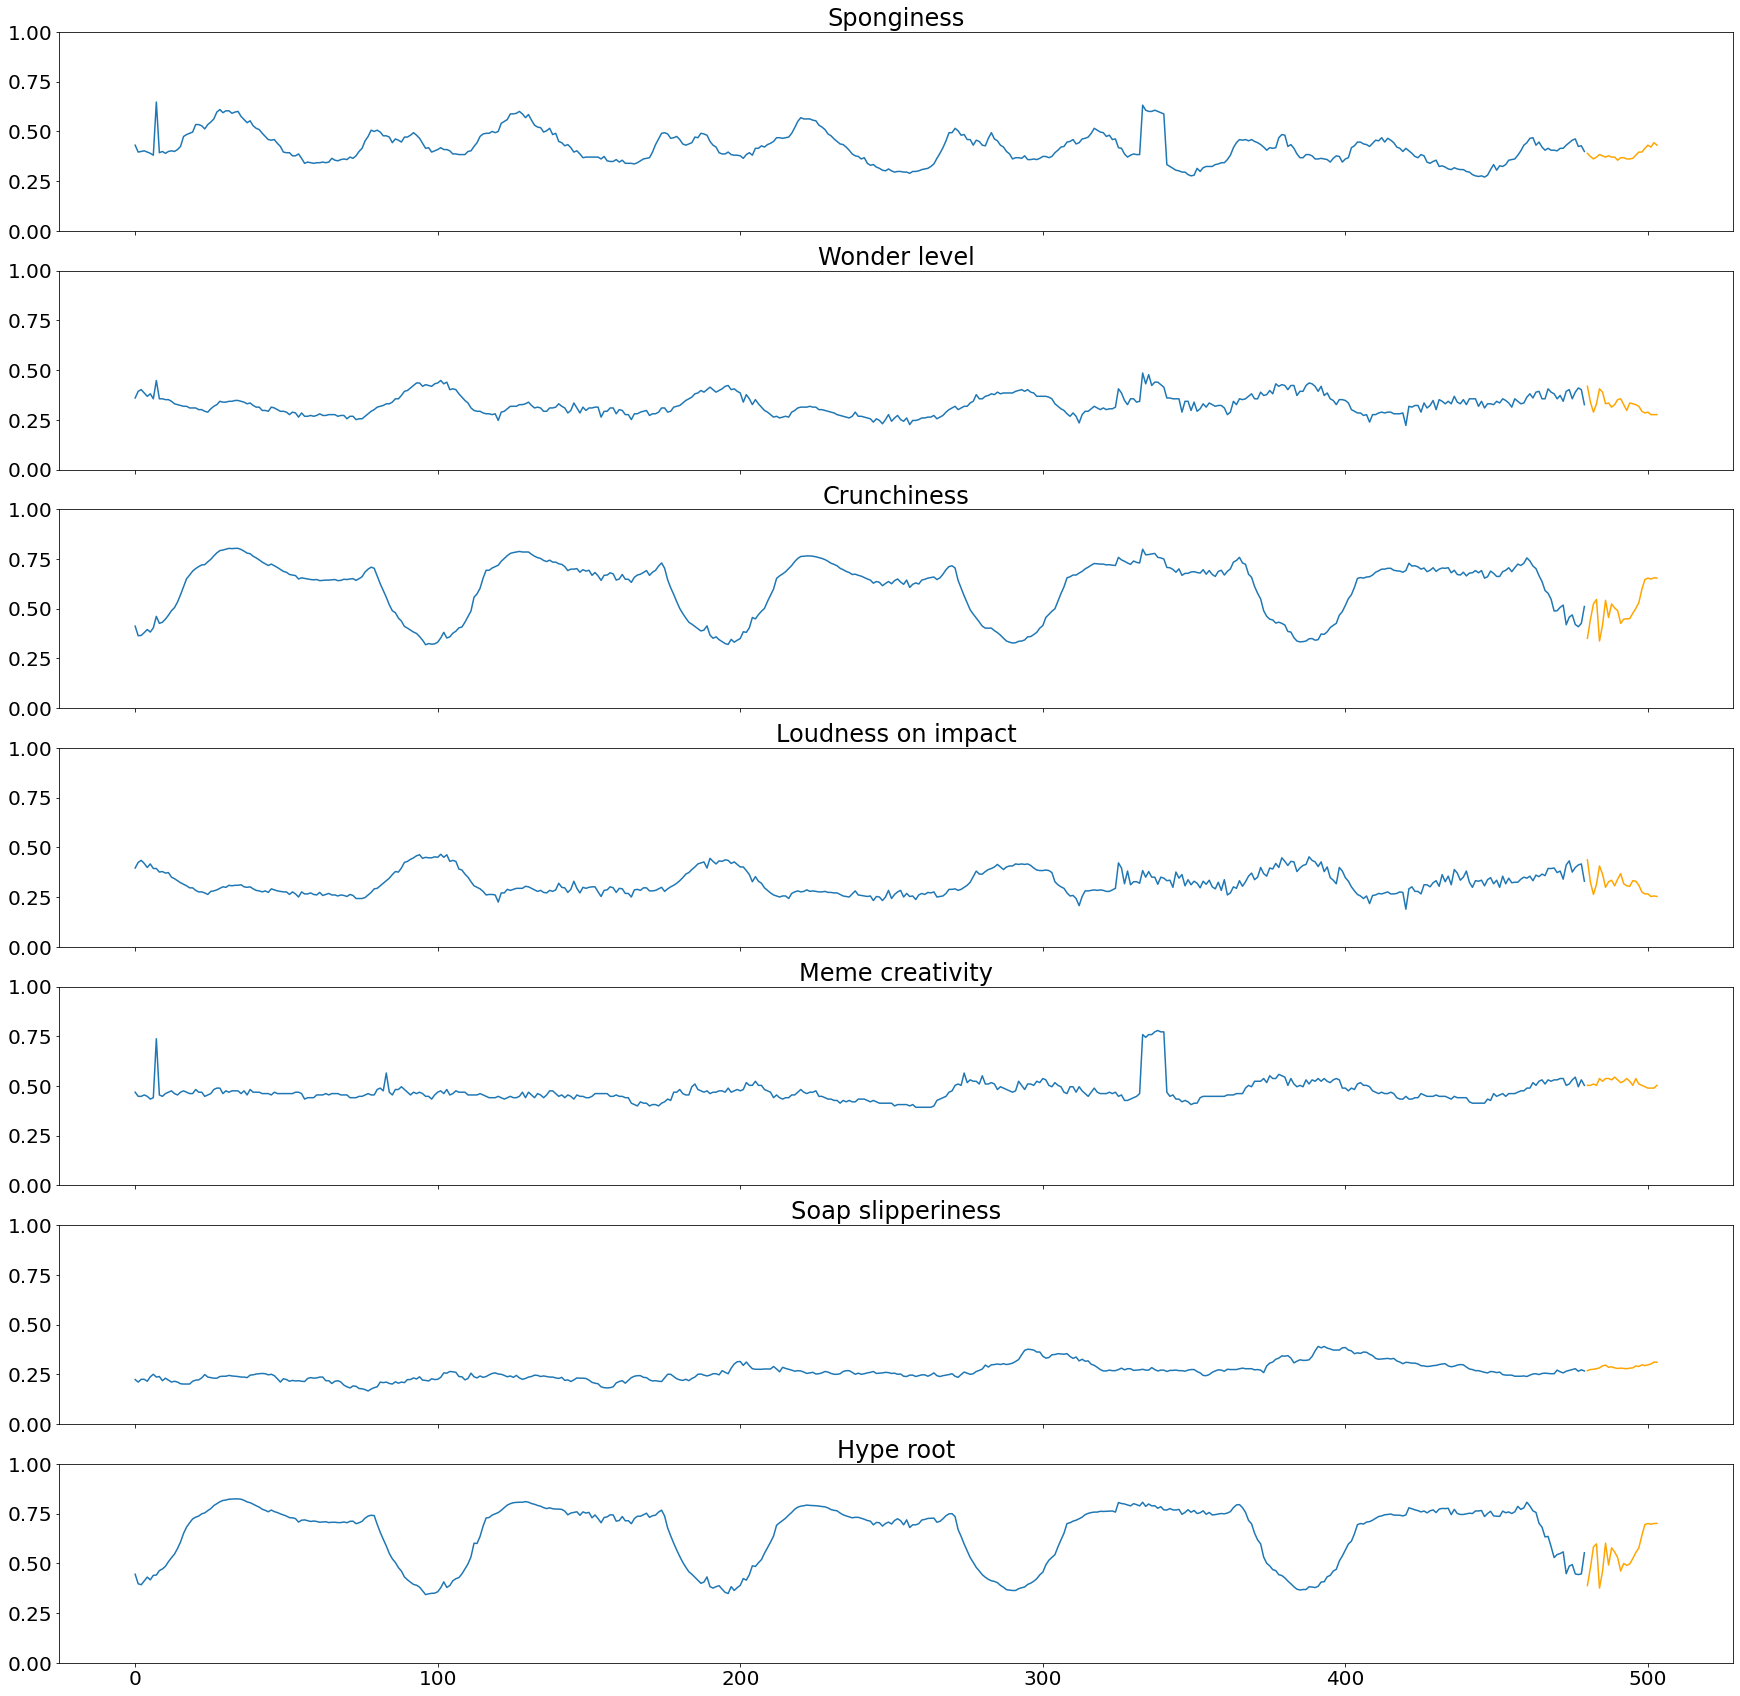

In [ ]:
inspect_multivariate(X_train, y_train, X_train_raw.columns, TARGET_LABELS)

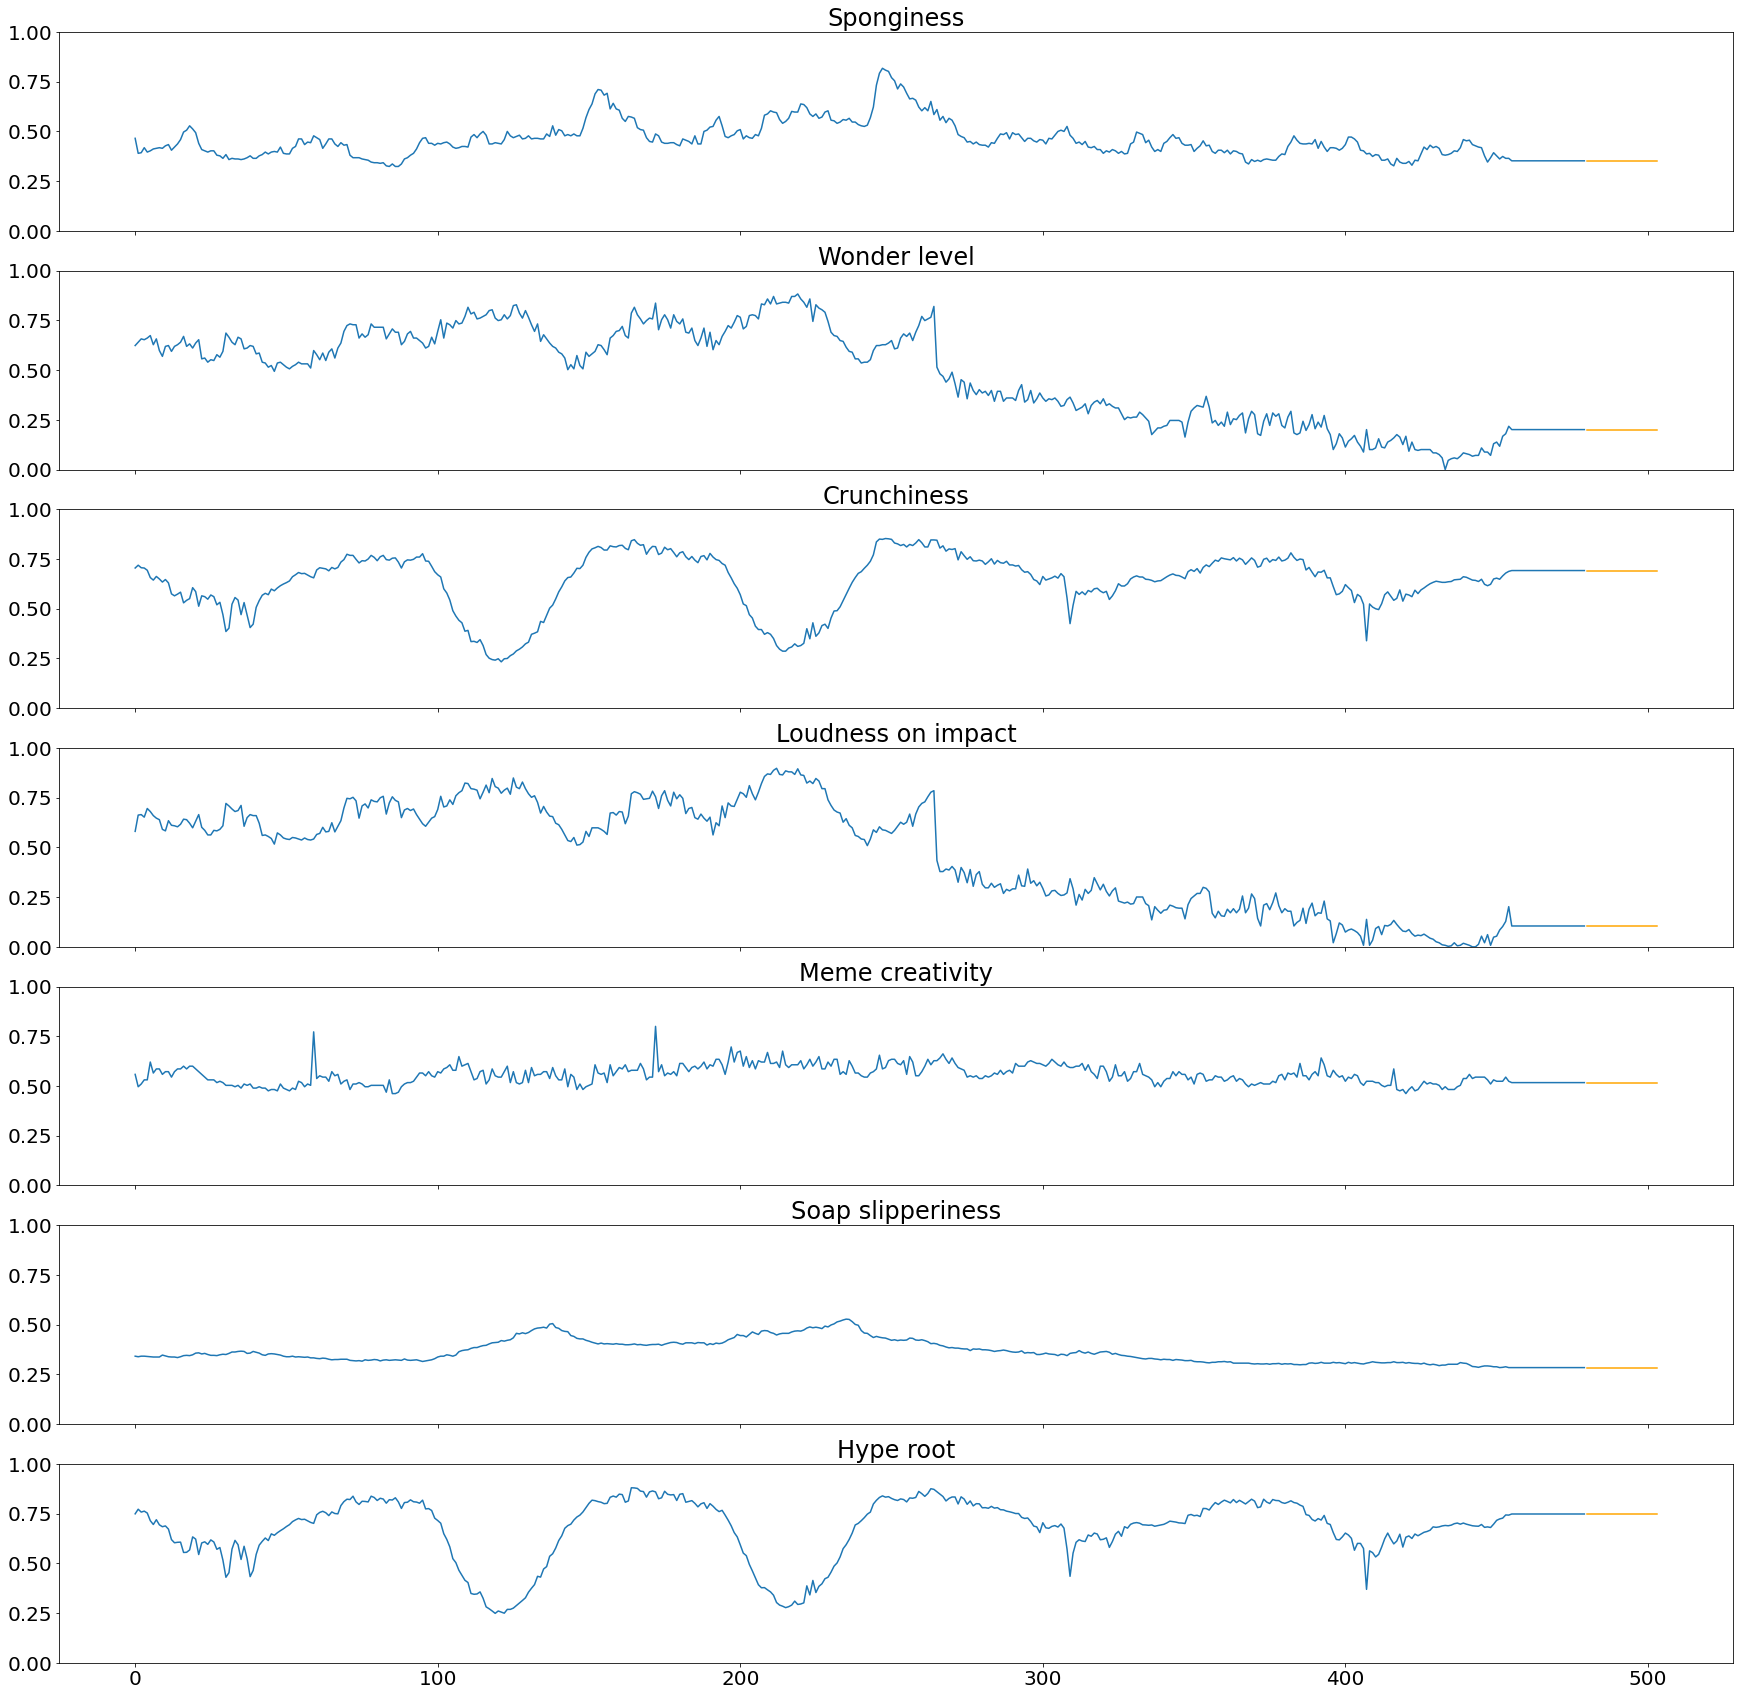

In [ ]:
inspect_multivariate(X_discarded, y_discarded, X_train_raw.columns, TARGET_LABELS)

# Building model with Transformer

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]

In [ ]:
input_shape, output_shape

((480, 7), (24, 7))

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = tfkl.LayerNormalization(epsilon=1e-6)(inputs)
    x = tfkl.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = tfkl.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = tfkl.LayerNormalization(epsilon=1e-6)(res)
    x = tfkl.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = tfkl.Dropout(dropout)(x)
    x = tfkl.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [ ]:
def build__TRANSFORMER_model(
    input_shape,
    output_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = tfkl.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    pool = tfkl.GlobalAveragePooling1D(data_format="channels_first")(x)

    # for dim in mlp_units:
    #     x = tfkl.Dense(dim, activation="relu")(x)
    #     x = tfkl.Dropout(mlp_dropout)(x)

    # dense layer
    dense = tfkl.Dense([output_shape[-1]*output_shape[-2]][0], activation='relu')(pool)
    dropout = tfkl.Dropout(mlp_dropout)(dense)
    
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dropout)
    output_layer = tfkl.Conv1D(output_shape[-1], 1, padding='same')(output_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=inputs, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

    return model

In [ ]:
model = build__TRANSFORMER_model(input_shape,
                                 output_shape,
                                 head_size = 64,
                                 num_heads = 2,
                                 ff_dim = 2,
                                 num_transformer_blocks = 2,
                                 mlp_units = 1,
                                 dropout = .3,
                                 mlp_dropout = 0.3)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 480, 7)]     0           []                               
                                                                                                  
 layer_normalization_12 (LayerN  (None, 480, 7)      14          ['input_7[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_6 (MultiH  (None, 480, 7)      3975        ['layer_normalization_12[0][0]', 
 eadAttention)                                                    'layer_normalization_12[0][0]'] 
                                                                                              

In [ ]:
# Train the model

history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = BATCH_SIZE,
    epochs = EPOCHES,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
38/38 [==============================] - 7s 131ms/step - loss: 0.2706 - mae: 0.4432 - val_loss: 0.1916 - val_mae: 0.3748 - lr: 0.0010
Epoch 2/200
38/38 [==============================] - 5s 119ms/step - loss: 0.1805 - mae: 0.3633 - val_loss: 0.1488 - val_mae: 0.3249 - lr: 0.0010
Epoch 3/200
38/38 [==============================] - 4s 118ms/step - loss: 0.1424 - mae: 0.3190 - val_loss: 0.1128 - val_mae: 0.2804 - lr: 0.0010
Epoch 4/200
38/38 [==============================] - 5s 119ms/step - loss: 0.1121 - mae: 0.2789 - val_loss: 0.0841 - val_mae: 0.2410 - lr: 0.0010
Epoch 5/200
38/38 [==============================] - 5s 119ms/step - loss: 0.0889 - mae: 0.2427 - val_loss: 0.0608 - val_mae: 0.2033 - lr: 0.0010
Epoch 6/200
38/38 [==============================] - 4s 118ms/step - loss: 0.0725 - mae: 0.2139 - val_loss: 0.0466 - val_mae: 0.1774 - lr: 0.0010
Epoch 7/200
38/38 [==============================] - 4s 118ms/step - loss: 0.0616 - mae: 0.1942 - val_loss: 0.0368 - val_mae

In [ ]:
# model.save('Erica_transformer_4_constant_values_removed')
model = tfk.models.load_model('Erica_transformer_4_constant_values_removed')

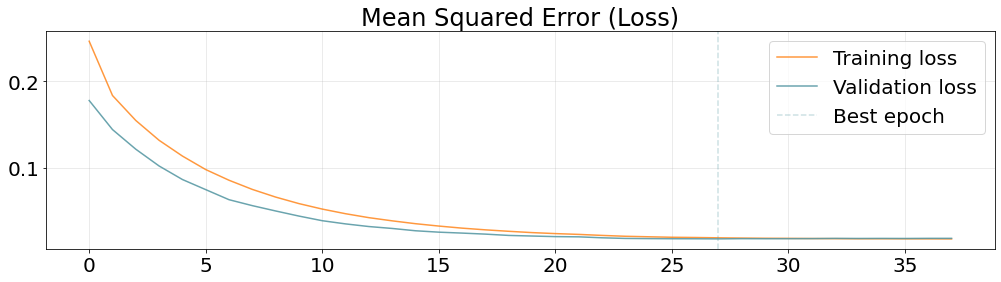

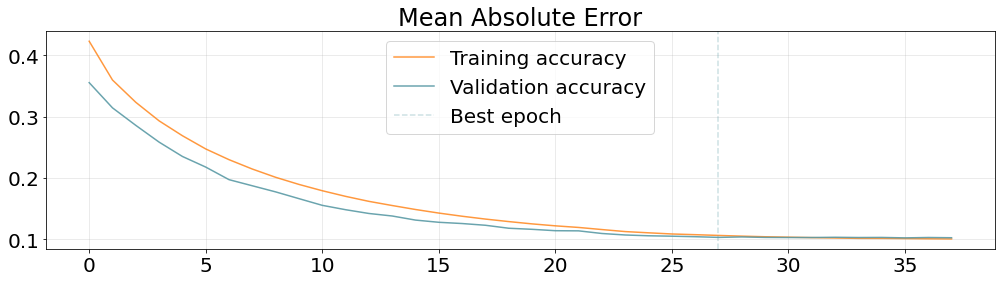

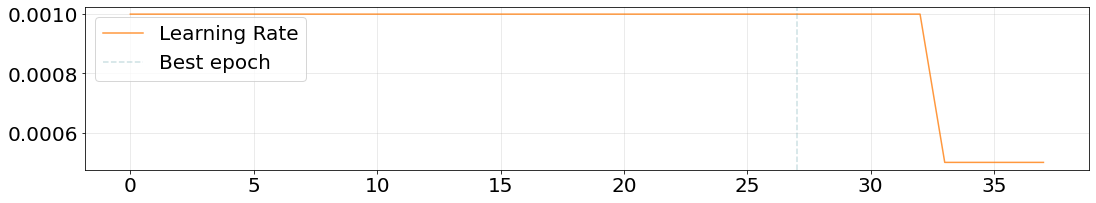

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
predictions = model.predict(X_test)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y_test.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test.flatten(),predictions.flatten())
mean_squared_error, mean_absolute_error

(15, 24, 7)


(<tf.Tensor: shape=(), dtype=float32, numpy=0.058640834>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.20125851>)

In [ ]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

In [ ]:
X_test.shape, y_test.shape

((15, 480, 7), (15, 24, 7))

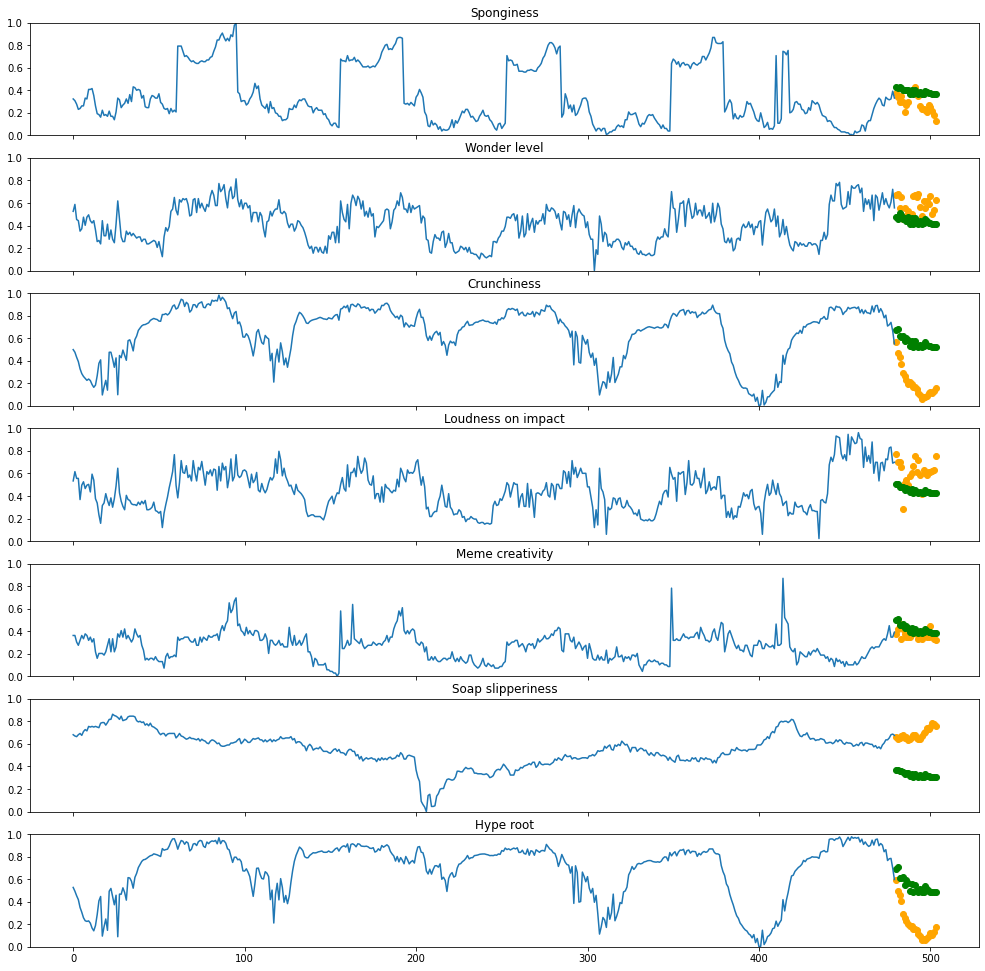

In [ ]:
inspect_multivariate_prediction(X_test, y_test, predictions, TARGET_LABELS, TELESCOPE)

# direi che non ha imparato nulla

### Autoregressor

In [ ]:
X_test_reg, y_test_reg, _,_ = build_sequences(X_test_raw, WINDOW_SIZE, TARGET_LABELS, reg_telescope, STRIDE)
X_test_reg.shape, y_test_reg.shape

100%|██████████| 12/12 [00:00<00:00, 3621.50it/s]


((12, 480, 7), (12, 100, 7))

In [ ]:
reg_telescope = 864
reg_predictions = np.array([])
X_temp = X_test_reg

# per ogni iterazione in telescope predictiamo la nostra x_temp, poi mettiamo X_temp è la concatenazione di lui discardando il primo punto e aggiungiamo quello predetto
for reg in range(reg_telescope//TELESCOPE):
    pred_temp = model.predict(X_temp)
    if(len(reg_predictions)==0):
        reg_predictions = pred_temp
    else:
        reg_predictions = np.concatenate((reg_predictions,pred_temp),axis=1)
    X_temp = np.concatenate((X_temp[:,TELESCOPE:,:],pred_temp), axis=1)         

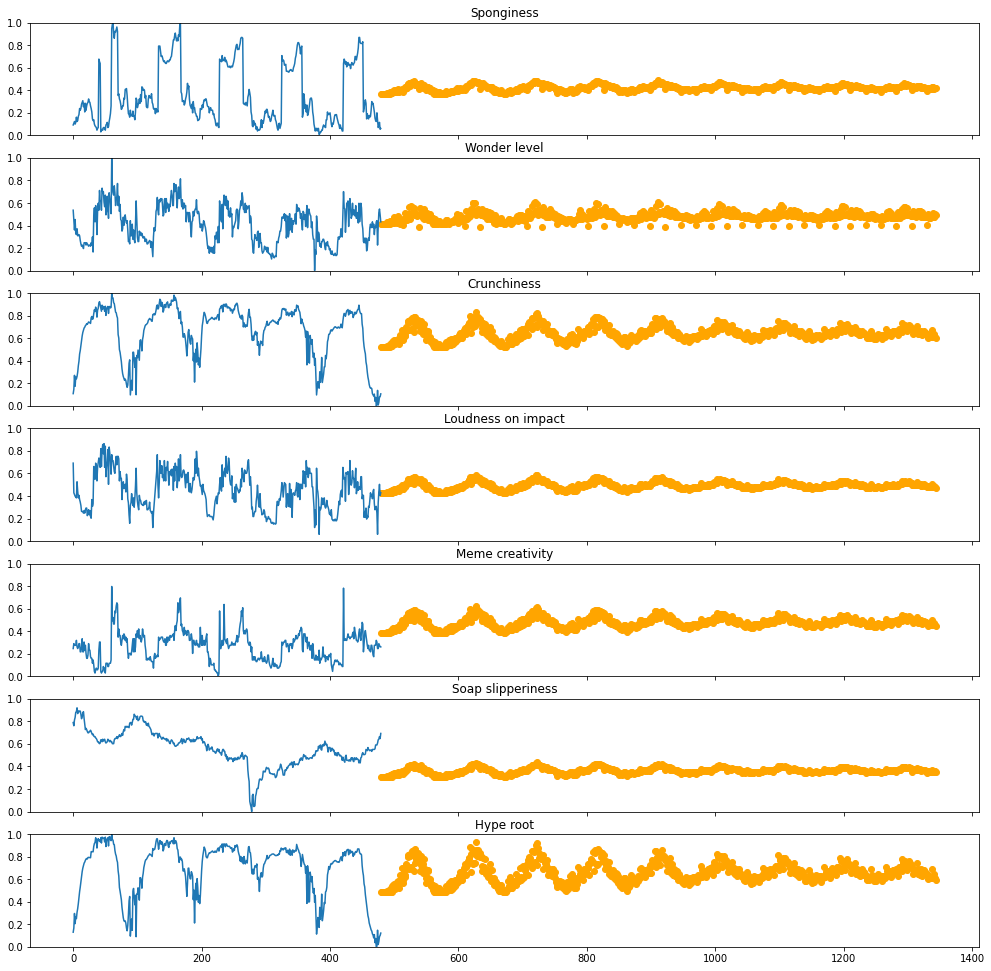

In [ ]:
columns = df.columns
X = X_test_reg
idx=np.random.randint(0,len(X))

figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
for i, col in enumerate(columns):
    axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
    axs[i].scatter(np.arange(len(X[0,:,i]), len(X[0,:,i])+len(reg_predictions[idx,:,i])), reg_predictions[idx,:,i], color='orange')
    axs[i].set_title(col)
    axs[i].set_ylim(0,1)
plt.show()